<a href="https://colab.research.google.com/github/sankardevisharath/amex-default-prediction/blob/master/notebooks/Feature_Selection_LGBMClassifier_on_agg_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import gc 

import numpy as np
import pandas as pd
import lightgbm as gbm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt


In [2]:
df = pd.read_parquet(path='/content/drive/MyDrive/amex-default-prediction/data/aggr/customer-agg.parquet')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458913 entries, 0 to 458912
Columns: 920 entries, customer_ID to target
dtypes: float64(891), int64(26), object(3)
memory usage: 3.1+ GB


In [4]:
columns = df.head().dtypes
columns[columns==object]


customer_ID    object
D_63_last      object
D_64_last      object
dtype: object

In [5]:
cat_cols = ['D_63', 'D_64','B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
TRAIN_LABELS_PATH = '/content/train_labels.csv'

In [6]:
X = pd.DataFrame()
Y = pd.DataFrame()

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[['D_63_last', 'D_64_last']]=enc.fit(df[['D_63_last', 'D_64_last']])
df[['D_63_last', 'D_64_last']]=enc.transform(df[['D_63_last', 'D_64_last']])
df.fillna(0, inplace=True)
X= X.append(df.loc[:, ~df.columns.isin(['customer_ID', 'target'])])
Y = Y.append(df.loc[:, df.columns == 'target'])

In [19]:
clf = gbm.LGBMClassifier()
sgd = SGDClassifier()

In [20]:
%%time
sgd.fit(X,Y.to_numpy().ravel())

CPU times: user 48.9 s, sys: 45.5 ms, total: 49 s
Wall time: 48.8 s


SGDClassifier()

In [23]:
%%time
sfs = SelectFromModel(sgd, prefit=True)


CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 21 µs


In [26]:
sfs.get_support().sum()

279

In [35]:
X_New = sfs.transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [37]:
X_New.shape

(458913, 279)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_New, Y, test_size=0.2)

In [40]:
clf.fit(X_train, y_train.values.ravel())

LGBMClassifier()

In [42]:
clf.score(X_test, y_test)

0.9007659370471656

In [43]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [44]:
y_pred = clf.predict(X_test)

In [45]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [46]:
tn, fp, fn, tp

(63497, 4611, 4497, 19178)

In [47]:
f1_score(y_test, y_pred)

0.8081071970335412

In [50]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9339    0.9323    0.9331     68108
           1     0.8062    0.8101    0.8081     23675

    accuracy                         0.9008     91783
   macro avg     0.8700    0.8712    0.8706     91783
weighted avg     0.9009    0.9008    0.9008     91783



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


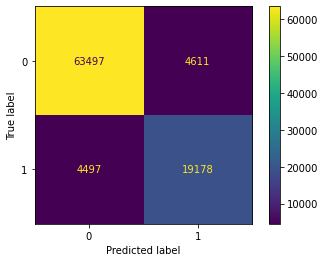

In [53]:
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

In [62]:
cols = sgd.feature_names_in_[sfs.get_support()]

In [63]:
feature_importance_df = pd.DataFrame(
    {'feature': cols ,
     'importance': clf.feature_importances_})

In [64]:
feature_importance_df.sort_values(by='importance', ascending=False).head(600)

,feature,importance
3,P_2_last,162
7,D_39_last,98
35,B_4_last,86
22,B_3_last,85
9,B_1_last,78
...,...,...
243,D_106_std,0
167,R_7_min,0
198,R_16_min,0
252,B_40_min,0
